In [153]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

from display import cm, format_axis, props, bar_format
from ode import ODE

In [154]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
default_type = torch.float32
torch.set_default_dtype(default_type)

In [155]:
method = 'dopri5'
adjoint = False

In [156]:
import pandas as pd

from tqdm import tqdm
from itertools import product

from torch.fft import fft2, ifft2, fftshift, ifftshift
from torchdiffeq import odeint, odeint_adjoint



class TorchRegularGridInterpolator:
    # Adapted from https://github.com/sbarratt/torch_interpolations, which is licensed under the Apache License 2.0
    def __init__(self, points, values):
        self.points = points
        self.values = values

        assert isinstance(self.points, tuple) or isinstance(self.points, list)
        assert isinstance(self.values, torch.Tensor)

        self.ms = list(self.values.shape)
        self.n = len(self.points)

        assert len(self.ms) == self.n

        for i, p in enumerate(self.points):
            assert isinstance(p, torch.Tensor)
            assert p.shape[0] == self.values.shape[i]

            
    def __call__(self, points_to_interp):
        assert self.points is not None
        assert self.values is not None

        assert len(points_to_interp) == len(self.points)
        K = points_to_interp[0].shape[0]
        for x in points_to_interp:
            assert x.shape[0] == K

        idxs = []
        dists = []
        overalls = []
        for p, x in zip(self.points, points_to_interp):
            idx_right = torch.bucketize(x, p)
            idx_right[idx_right >= p.shape[0]] = p.shape[0] - 1
            idx_left = (idx_right - 1).clamp(0, p.shape[0] - 1)
            
            dist_left = x - p[idx_left]
            dist_right = p[idx_right] - x
            dist_left[dist_left < 0] = 0.
            dist_right[dist_right < 0] = 0.
            both_zero = (dist_left == 0) & (dist_right == 0)
            dist_left[both_zero] = dist_right[both_zero] = 1.

            idxs.append((idx_left, idx_right))
            dists.append((dist_left, dist_right))
            overalls.append(dist_left + dist_right)

        numerator = 0.
        for indexer in product([0,1], repeat=self.n):
            as_s = [idx[onoff] for onoff, idx in zip(indexer, idxs)]
            bs_s = [dist[1 - onoff] for onoff, dist in zip(indexer, dists)]
            numerator += self.values[as_s]*torch.prod(torch.stack(bs_s), dim=0)
        denominator = torch.prod(torch.stack(overalls), dim=0)
        return numerator/denominator
    
    
    
class Spiral(ODE):
    def __init__(self, args, method='dopri5', default_type=torch.float64):
        super(Spiral, self).__init__(method, adjoint=False, requires_grad=False)
        
        default_args = {'dirname': 'Experiments/',
                        'run': 0,
                        'w': 4.
                       }
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
    def load_exp(self):
        # set paths
        self.positions_path = self.dirname + 'raw/positions.csv'
        self.object_path = self.dirname + 'data/run{:g}_object_0.csv'.format(self.run)
        self.probe_path = self.dirname + 'data/run{:g}_probe_0.csv'.format(self.run)
        self.probes_path = self.dirname + 'data/run{:g}_probes_0.csv'.format(self.run)
        
        # read in detector positions and convert to um
        self.pos = pd.read_csv(self.positions_path, header=None, names=('y','x'))
        self.pos.x *= 1e6
        self.pos.y *= 1e6
        ic = (self.pos.x**2 + self.pos.y**2).argmin()
        self.xc, self.yc = self.pos.x[ic], self.pos.y[ic]
        
        # read object
        self.obj = torch.from_numpy(np.genfromtxt(self.object_path, delimiter=',', dtype=np.complex64))
        
        # read probe
        self.probe = torch.from_numpy(np.genfromtxt(self.probe_path, delimiter=',', dtype=np.complex64))
        self.probes = torch.from_numpy(np.genfromtxt(self.probes_path, delimiter=',', dtype=np.complex64))
    
        # real space grid
        self.p = 6.82e-3 # object and probe pixel lengths (um)
        h, w = self.obj.shape
        self.obj_x = self.p*torch.arange(w)
        self.obj_y = self.p*torch.arange(h)
        self.obj_x -= self.obj_x.mean()
        self.obj_y -= self.obj_y.mean()
        self.obj_X, self.obj_Y = torch.meshgrid(self.obj_x, self.obj_y, indexing='xy')
        self.f_obj = TorchRegularGridInterpolator((self.obj_y, self.obj_x), self.obj)
        
        h, w = self.probe.shape
        self.probe_x = self.p*torch.arange(w)
        self.probe_y = self.p*torch.arange(h)
        self.probe_x -= self.probe_x.mean()
        self.probe_y -= self.probe_y.mean()
        self.probe_X, self.probe_Y = torch.meshgrid(self.probe_x, self.probe_y, indexing='xy')
        
        self.probes = self.probes.reshape(-1,h,w)

        # read data
        self.data = np.zeros((len(self.pos),512,512))
        for i in tqdm(range(len(self.pos)), bar_format=bar_format, desc='Parse data'):
            self.data[i] = np.fromfile(self.dirname + 'raw/image_{:06d}.bin'.format(i),
                                       dtype=np.float32).reshape(h,w)
        self.data = torch.from_numpy(self.data)
        
    
    def cxs(self, y):
        y = y.unsqueeze(-2)
        p = self.f_obj((self.probe_Y + y[...,[1]], self.probe_X + y[...,[0]]))*self.probes
        return fftshift(torch.abs(fft2(ifftshift(p)))**2).sum(dim=-3)
    
    
    def init_state(self, *y0):
        r"""Define the initial state(s) of the ODE system.
                
        """
        self.y0 = nn.Parameter(torch.tensor(y0).view(1,1,-1), requires_grad=False)
        
        
    def forward(self, t, y):
        r"""Evaluate the ODE system at a specified time ``t`` and state ``y``.
            
        Parameters
        ----------
        t : ``torch.tensor``
            1-dimensional tensor of the evaluation time point.
        
        y : ``torch.tensor`` of shape ``(M,N,3)``
            State of the system for ``M`` initial conditions.
                
        Returns
        -------
        dy/dt : ``torch.tensor`` of shape ``(M,N,3)``
            Derivative of the system.
                
        """
        _x, _y, _z = y.split([1,1,1], dim=-1)
        dz = 0.5/_z
        dx = dz*((_x - self.xc)/_z - self.w*(_y - self.yc))
        dy = dz*((_y - self.yc)/_z + self.w*(_x - self.xc))
        return torch.cat([dx, dy, dz], dim=-1)

In [157]:
args = {'dirname': '../../Experiments/811/',
        'run': 0,
        'w': 4.
       }

scan = Spiral(args, method, default_type)
scan.load_exp()
scan.init_state((3.06643667e-02, 3.69691779e-02, 1.))
scan.to(device)

t = torch.arange(1, 756, dtype=default_type)
scan.solve(t, device=device)

Parse data: 100%|██████████| 963/963 [00:00<00:00, 1442.25it/s]                 


Elapsed time: 0.33 s


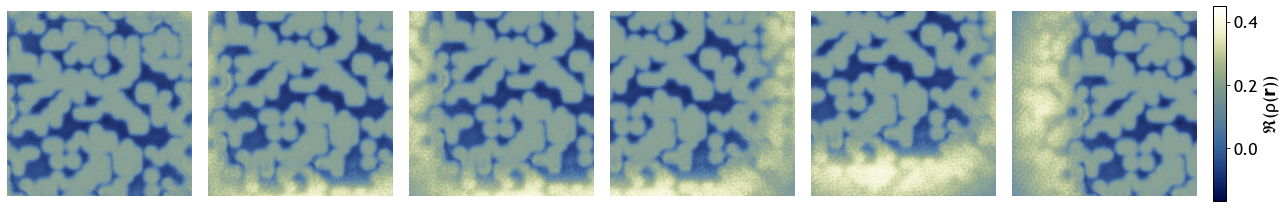

In [158]:
fig = scan.plot_series(scan.f_obj((scan.probe_Y + scan.y[::126,...,1], scan.probe_X + scan.y[::126,...,0])).real,
                       ntype=None, clabel=r'$\Re(\rho(\mathbf{r}))$')

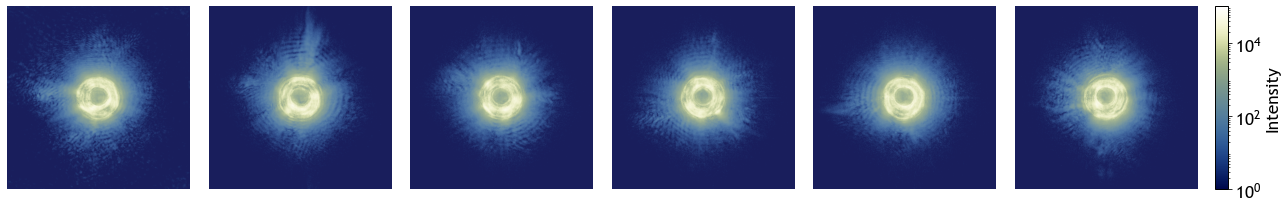

In [159]:
fig = scan.plot_series(scan.cxs(scan.y[::126])[:,0], ntype='log', vmin=1e0, vmax=1e5, clabel='Intensity')

In [160]:
def get_path(self):
    points = torch.from_numpy(np.array([self.pos.x, self.pos.y]).T.reshape(-1,2)).view(-1,1,1,2)
    self._i = torch.zeros(self.y.shape[:2], dtype=int)
    self._y = torch.zeros_like(self.y)
    self._y[...,-1] = self.y[...,-1].clone()
    for i in range(len(self.y)):
        self._i[i] = torch.square(self.y[[i],...,:2] - points).sum(dim=-1).argmin()
        self._y[i,...,:2] = points[self._i[i]]

In [161]:
get_path(scan)

In [163]:
def get_batch(self, batch_time, batch_size):
        r"""Sample a batch of ``t``, ``y0``, and ``y``.
        
        Parameters
        ----------
        batch_time : int
            Number of time points per batch.

        batch_size : int
            Number of initial conditions per batch.

        Returns
        -------
        t : ``torch.tensor`` of shape ``(batch_time)``
            Tensor of ``batch_time`` time points.
            
        y0 : ``torch.tensor`` of shape ``(batch_size,...,D)``
            Initial states for ``batch_size`` initial conditions.
            
        y : ``torch.tensor`` of shape ``(batch_time,batch_size,...,D)``
            Solution evaluated at ``batch_time`` time points for ``batch_size`` initial conditions.
            
        """
        T, M, _, D = self.y.shape
        t_batch = self.t[:batch_time]

        c = [[i,j] for i in range(T - batch_time) for j in range(M)]
        b = [c[i] for i in np.random.choice(len(c), batch_size, replace=False)]

        for i in range(len(b)):
            if i==0:
                y0_batch = self._y[b[i][0], b[i][1]][None,:]
                y_batch = torch.stack([self._y[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None,:]
                i_batch = torch.stack([self._i[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None]
            else:
                y0_batch = torch.cat((y0_batch, self._y[b[i][0], b[i][1]][None,:]))
                y_batch = torch.cat(
                    (y_batch, torch.stack([self._y[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None,:]),
                    dim=1)
                i_batch = torch.cat(
                    (i_batch, torch.stack([self._i[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None]),
                    dim=1)
        return t_batch, y0_batch, y_batch, i_batch

In [227]:
batch_time = 20
batch_size = 5
t_batch, y0_batch, y_batch, i_batch = get_batch(scan, batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)
print(' i:', i_batch.shape)

 t: torch.Size([20])
y0: torch.Size([5, 1, 3])
 y: torch.Size([20, 5, 1, 3])
 i: torch.Size([20, 5])


In [228]:
scan.cxs(y_batch)
ti = time.time()
Y_batch = scan.cxs(y_batch)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

Elapsed time: 1.013 s


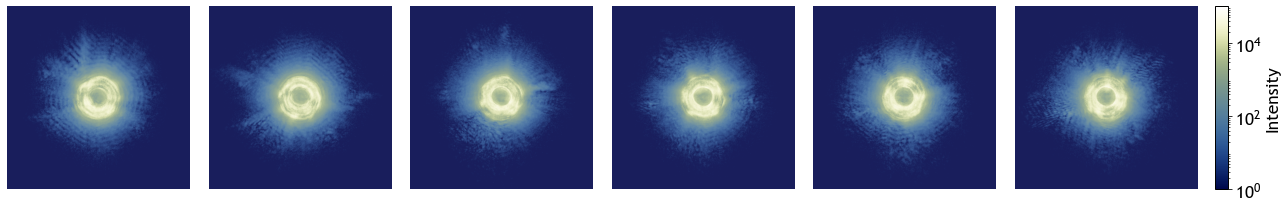

In [229]:
fig = scan.plot_series(Y_batch[:,0], ntype='log', vmin=1e0, vmax=1e5, clabel='Intensity')

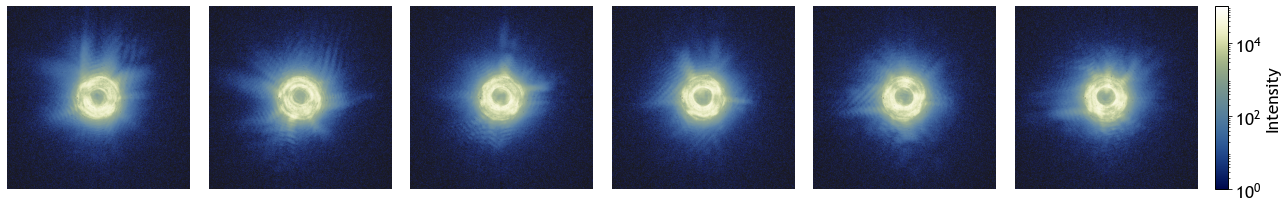

In [230]:
fig = scan.plot_series(scan.data[i_batch][:,0], ntype='log', vmin=1e0, vmax=1e5, clabel='Intensity')

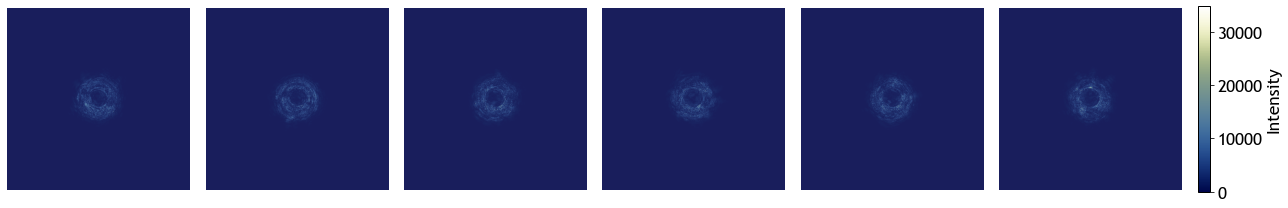

In [231]:
fig = scan.plot_series(torch.abs(Y_batch[:,0]-scan.data[i_batch][:,0]), ntype=None, clabel='Intensity')

In [32]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'dirname': 'Experiments/',
                        'run': 0
                       }
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
            
        self.F = nn.Sequential(
            nn.Linear(2,10),
            nn.Tanh(),
            nn.Linear(10,2)
        )
        
        
    def load_exp(self):
        # set paths
        self.positions_path = self.dirname + 'raw/positions.csv'
        self.object_path = self.dirname + 'data/run{:g}_object_0.csv'.format(self.run)
        self.probe_path = self.dirname + 'data/run{:g}_probe_0.csv'.format(self.run)
        self.probes_path = self.dirname + 'data/run{:g}_probes_0.csv'.format(self.run)
        
        # read in detector positions and convert to um
        self.pos = pd.read_csv(self.positions_path, header=None, names=('y','x'))
        self.pos.x *= 1e6
        self.pos.y *= 1e6
        ic = (self.pos.x**2 + self.pos.y**2).argmin()
        self.xc, self.yc = self.pos.x[ic], self.pos.y[ic]
        
        # read object
        self.obj = torch.from_numpy(np.genfromtxt(self.object_path, delimiter=',', dtype=np.complex64))
        
        # read probe
        self.probe = torch.from_numpy(np.genfromtxt(self.probe_path, delimiter=',', dtype=np.complex64))
        self.probes = torch.from_numpy(np.genfromtxt(self.probes_path, delimiter=',', dtype=np.complex64))
    
        # real space grid
        self.p = 6.82e-3 # object and probe pixel lengths (um)
        h, w = self.obj.shape
        self.obj_x = self.p*torch.arange(w)
        self.obj_y = self.p*torch.arange(h)
        self.obj_x -= self.obj_x.mean()
        self.obj_y -= self.obj_y.mean()
        self.obj_X, self.obj_Y = torch.meshgrid(self.obj_x, self.obj_y, indexing='xy')
        self.f_obj = TorchRegularGridInterpolator((self.obj_y, self.obj_x), self.obj)
        
        h, w = self.probe.shape
        self.probe_x = self.p*torch.arange(w)
        self.probe_y = self.p*torch.arange(h)
        self.probe_x -= self.probe_x.mean()
        self.probe_y -= self.probe_y.mean()
        self.probe_X, self.probe_Y = torch.meshgrid(self.probe_x, self.probe_y, indexing='xy')
        
        self.probes = self.probes.reshape(-1,h,w)

        # read data
        self.data = np.zeros((len(self.pos),512,512))
        for i in tqdm(range(len(self.pos)), bar_format=bar_format, desc='Parse data'):
            self.data[i] = np.fromfile(self.dirname + 'raw/image_{:06d}.bin'.format(i),
                                       dtype=np.float32).reshape(h,w)
        self.data = torch.from_numpy(self.data)
        
        
    def cxs(self, y):
        y = y.unsqueeze(-2)
        p = self.f_obj((self.probe_Y + y[...,[1]], self.probe_X + y[...,[0]]))*self.probes
        return fftshift(torch.abs(fft2(ifftshift(p)))**2).sum(dim=-3)
                
    
    def loss(self, y_true, y_pred):
        return nn.L1Loss()(self.data[y_true], self.cxs(y_pred))
        
        
    def forward(self, t, y):
        N = y.shape[-2]
        y_mean = y.mean(dim=-2, keepdims=True)
        dy = self.F(y_mean)
        return torch.tile(dy, (1, N, 1))

In [33]:
method = 'dopri5'
adjoint = False
args = {'dirname': '../../Experiments/811/',
        'run': 0
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.load_exp()
optimizer = optim.Adam(node.parameters(), lr=1e-2)
print(node)

Parse data: 100%|██████████| 963/963 [00:00<00:00, 1447.08it/s]                 

NODE(
  (F): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)
